In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import math
from scipy import stats
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
Data=pd.read_csv('Data.csv',sep=';')

In [3]:
Data

,DEBTOR_NO,RAND_NO,SNAPSHOT_DATE,IS_PAID_12M,IS_PAID_6M,IS_PAID_3M,IS_PAID_AMT_12M,IS_PAID_AMT_6M,IS_PAID_AMT_3M,CASE_AGE_MONTHS,INTEREST_RATE,REM_PRINCIPAL_AMT,REM_PRINCIPAL_INTEREST_AMT,REM_TOTAL_AMT,DEBTOR_AGE,PAID_AMT_12M,PAID_AMT_6M,PAID_AMT_3M,INCOME_TOTAL_LAST_YEAR,TOTAL_DEBT_AMT
0,1,53390578,2019-12-31,0,0,0,0,0,0,98,27,3000.0,10000,11000,45,0,0,0,0.0,67233
1,2,72536782,2019-12-31,0,0,0,0,0,0,96,26,18000.0,47000,47000,28,0,0,0,54004.0,152604
2,3,6806414,2019-12-31,0,0,0,0,0,0,92,9,3000.0,6000,6000,22,0,0,0,113829.0,42052
3,4,6277796,2019-12-31,0,0,0,0,0,0,98,26,9000.0,23000,24000,22,0,0,0,191168.0,62821
4,5,69339423,2019-12-31,0,0,0,0,0,0,98,26,1000.0,4000,5000,54,0,0,0,185517.0,45237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16141,16142,77324789,2019-12-31,0,0,0,0,0,0,4,26,1000.0,1000,2000,19,0,0,0,NaN,0
16142,16143,18997081,2019-12-31,0,0,0,0,0,0,4,25,0.0,0,0,65,0,0,0,NaN,82045
16143,16144,99944263,2019-12-31,1,0,0,378,0,0,4,26,0.0,0,0,24,0,0,0,NaN,13462
16144,16145,24251613,2019-12-31,1,1,0,12752,884,0,4,23,20000.0,21000,22000,39,0,0,0,NaN,37923


In [4]:
# We have three columns which are our main targets IS_PAID_3M, IS_PAID_6M, IS_PAID_12M. We are intrested in knowing
# the likelihood of payment, so the next three columns IS_PAID_AMT_3M, IS_PAID_AMT_6M,IS_PAID_AMT_12M are not our intrest
# and do not help the likelihood.
# We have option of looking at the problem as binary-class task (is paid or not paid in 3 month, or 6, 12 months), or 
# multi-class problem (all three target columns). I choose the first one, becasue the binary class is easeir to learn
# and faster. However, I also tried multi-class and came to conclution that binary class is better.
# I investigate if the person pays in 3 months or not. Then one can reapeat the same code for 6 months and 12 months.

Data['Likelihood']=Data['IS_PAID_3M']

In [5]:
columns=['DEBTOR_NO','RAND_NO','IS_PAID_3M','IS_PAID_6M','IS_PAID_12M','IS_PAID_AMT_3M','IS_PAID_AMT_6M','IS_PAID_AMT_12M','SNAPSHOT_DATE']
Data=Data.drop(columns,axis=1)

In [6]:
Data.head(3)

,CASE_AGE_MONTHS,INTEREST_RATE,REM_PRINCIPAL_AMT,REM_PRINCIPAL_INTEREST_AMT,REM_TOTAL_AMT,DEBTOR_AGE,PAID_AMT_12M,PAID_AMT_6M,PAID_AMT_3M,INCOME_TOTAL_LAST_YEAR,TOTAL_DEBT_AMT,Likelihood
0,98,27,3000.0,10000,11000,45,0,0,0,0.0,67233,0
1,96,26,18000.0,47000,47000,28,0,0,0,54004.0,152604,0
2,92,9,3000.0,6000,6000,22,0,0,0,113829.0,42052,0


In [7]:
Data.describe()

,CASE_AGE_MONTHS,INTEREST_RATE,REM_PRINCIPAL_AMT,REM_PRINCIPAL_INTEREST_AMT,REM_TOTAL_AMT,DEBTOR_AGE,PAID_AMT_12M,PAID_AMT_6M,PAID_AMT_3M,INCOME_TOTAL_LAST_YEAR,TOTAL_DEBT_AMT,Likelihood
count,16146.000000,16146.000000,16145.000000,16146.000000,16146.000000,16146.00000,16146.000000,16146.000000,16146.000000,1.233600e+04,1.614600e+04,16146.000000
mean,28.331909,25.374210,7007.990090,12447.231512,12979.004088,39.43918,242.622693,80.279884,19.677815,1.374913e+05,1.615637e+05,0.056051
std,21.774728,5.374826,11536.160586,20782.066889,21008.116649,13.71734,1892.152897,846.441824,389.335378,1.301421e+05,4.284649e+05,0.230027
min,-1.000000,0.000000,0.000000,0.000000,0.000000,19.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,10.000000,24.000000,0.000000,1000.000000,1000.000000,27.00000,0.000000,0.000000,0.000000,7.127250e+03,1.743950e+04,0.000000
50%,23.000000,25.000000,2000.000000,3000.000000,4000.000000,38.00000,0.000000,0.000000,0.000000,1.200750e+05,5.553500e+04,0.000000
75%,39.000000,27.000000,9000.000000,16000.000000,17000.000000,49.00000,0.000000,0.000000,0.000000,2.192905e+05,1.708742e+05,0.000000
max,98.000000,50.000000,101000.000000,214000.000000,214000.000000,94.00000,56714.000000,37916.000000,36407.000000,1.647453e+06,2.954246e+07,1.000000


<AxesSubplot:xlabel='Likelihood', ylabel='count'>

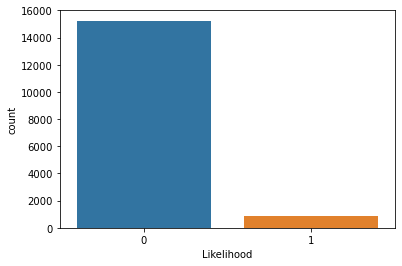

In [8]:
# The number of cases where the payment in 3 months occured or not occured. It tells us we have very imbalanced data.

sns.countplot(x='Likelihood',data=Data)

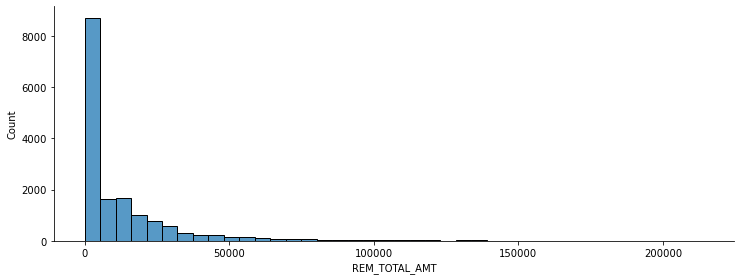

In [9]:
# For most cases the REM_TOTAL_AMT is less than 5000.
# We have non-gaussion distribution data. For example positively skewed below.

sns.displot(Data['REM_TOTAL_AMT'],kde=False,bins=40,height=4,aspect=2.6)

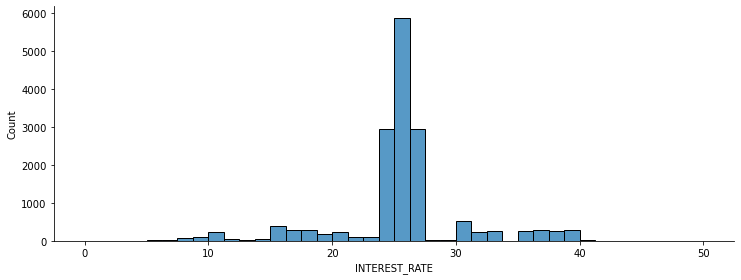

In [10]:
# The intrest rate is mostly around 25 percent. 

sns.displot(Data['INTEREST_RATE'],kde=False,bins=40,height=4,aspect=2.6)

In [11]:
# There are a lot of persons with zero income last year:

Data[(Data['INCOME_TOTAL_LAST_YEAR']==0)].count()

CASE_AGE_MONTHS               2854
INTEREST_RATE                 2854
REM_PRINCIPAL_AMT             2854
REM_PRINCIPAL_INTEREST_AMT    2854
REM_TOTAL_AMT                 2854
DEBTOR_AGE                    2854
PAID_AMT_12M                  2854
PAID_AMT_6M                   2854
PAID_AMT_3M                   2854
INCOME_TOTAL_LAST_YEAR        2854
TOTAL_DEBT_AMT                2854
Likelihood                    2854
dtype: int64

In [12]:
Data[(Data['TOTAL_DEBT_AMT']==0) ].count()

CASE_AGE_MONTHS               792
INTEREST_RATE                 792
REM_PRINCIPAL_AMT             791
REM_PRINCIPAL_INTEREST_AMT    792
REM_TOTAL_AMT                 792
DEBTOR_AGE                    792
PAID_AMT_12M                  792
PAID_AMT_6M                   792
PAID_AMT_3M                   792
INCOME_TOTAL_LAST_YEAR        486
TOTAL_DEBT_AMT                792
Likelihood                    792
dtype: int64

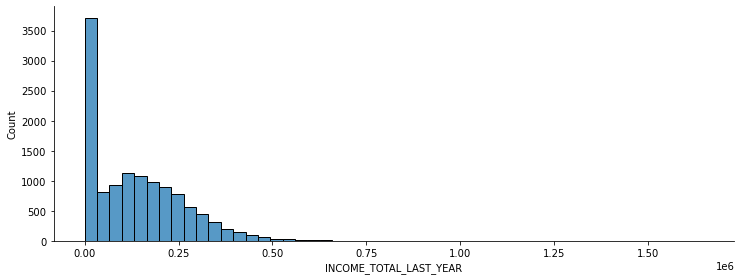

In [13]:
# The dictribution plot of income_last_year. As it is seen there are alot people with zero  income last year.

sns.displot(Data['INCOME_TOTAL_LAST_YEAR'],kde=False,bins=50,height=4,aspect=2.6)

In [14]:
# There are also people which do not have depth at all:

Data[(Data['TOTAL_DEBT_AMT']==0)  & (Data['REM_TOTAL_AMT']==0)].count()

CASE_AGE_MONTHS               273
INTEREST_RATE                 273
REM_PRINCIPAL_AMT             273
REM_PRINCIPAL_INTEREST_AMT    273
REM_TOTAL_AMT                 273
DEBTOR_AGE                    273
PAID_AMT_12M                  273
PAID_AMT_6M                   273
PAID_AMT_3M                   273
INCOME_TOTAL_LAST_YEAR        177
TOTAL_DEBT_AMT                273
Likelihood                    273
dtype: int64

In [15]:
# Null values in data:

Data.isnull().sum() 

CASE_AGE_MONTHS                  0
INTEREST_RATE                    0
REM_PRINCIPAL_AMT                1
REM_PRINCIPAL_INTEREST_AMT       0
REM_TOTAL_AMT                    0
DEBTOR_AGE                       0
PAID_AMT_12M                     0
PAID_AMT_6M                      0
PAID_AMT_3M                      0
INCOME_TOTAL_LAST_YEAR        3810
TOTAL_DEBT_AMT                   0
Likelihood                       0
dtype: int64

In [16]:
# Percentage of null values

100*Data.isnull().sum()/len(Data)

CASE_AGE_MONTHS                0.000000
INTEREST_RATE                  0.000000
REM_PRINCIPAL_AMT              0.006193
REM_PRINCIPAL_INTEREST_AMT     0.000000
REM_TOTAL_AMT                  0.000000
DEBTOR_AGE                     0.000000
PAID_AMT_12M                   0.000000
PAID_AMT_6M                    0.000000
PAID_AMT_3M                    0.000000
INCOME_TOTAL_LAST_YEAR        23.597176
TOTAL_DEBT_AMT                 0.000000
Likelihood                     0.000000
dtype: float64

In [17]:
# We drop null values for furthure exploring data

Cleaned_Data=Data.dropna(axis=0)
Cleaned_Data.head(3)

,CASE_AGE_MONTHS,INTEREST_RATE,REM_PRINCIPAL_AMT,REM_PRINCIPAL_INTEREST_AMT,REM_TOTAL_AMT,DEBTOR_AGE,PAID_AMT_12M,PAID_AMT_6M,PAID_AMT_3M,INCOME_TOTAL_LAST_YEAR,TOTAL_DEBT_AMT,Likelihood
0,98,27,3000.0,10000,11000,45,0,0,0,0.0,67233,0
1,96,26,18000.0,47000,47000,28,0,0,0,54004.0,152604,0
2,92,9,3000.0,6000,6000,22,0,0,0,113829.0,42052,0


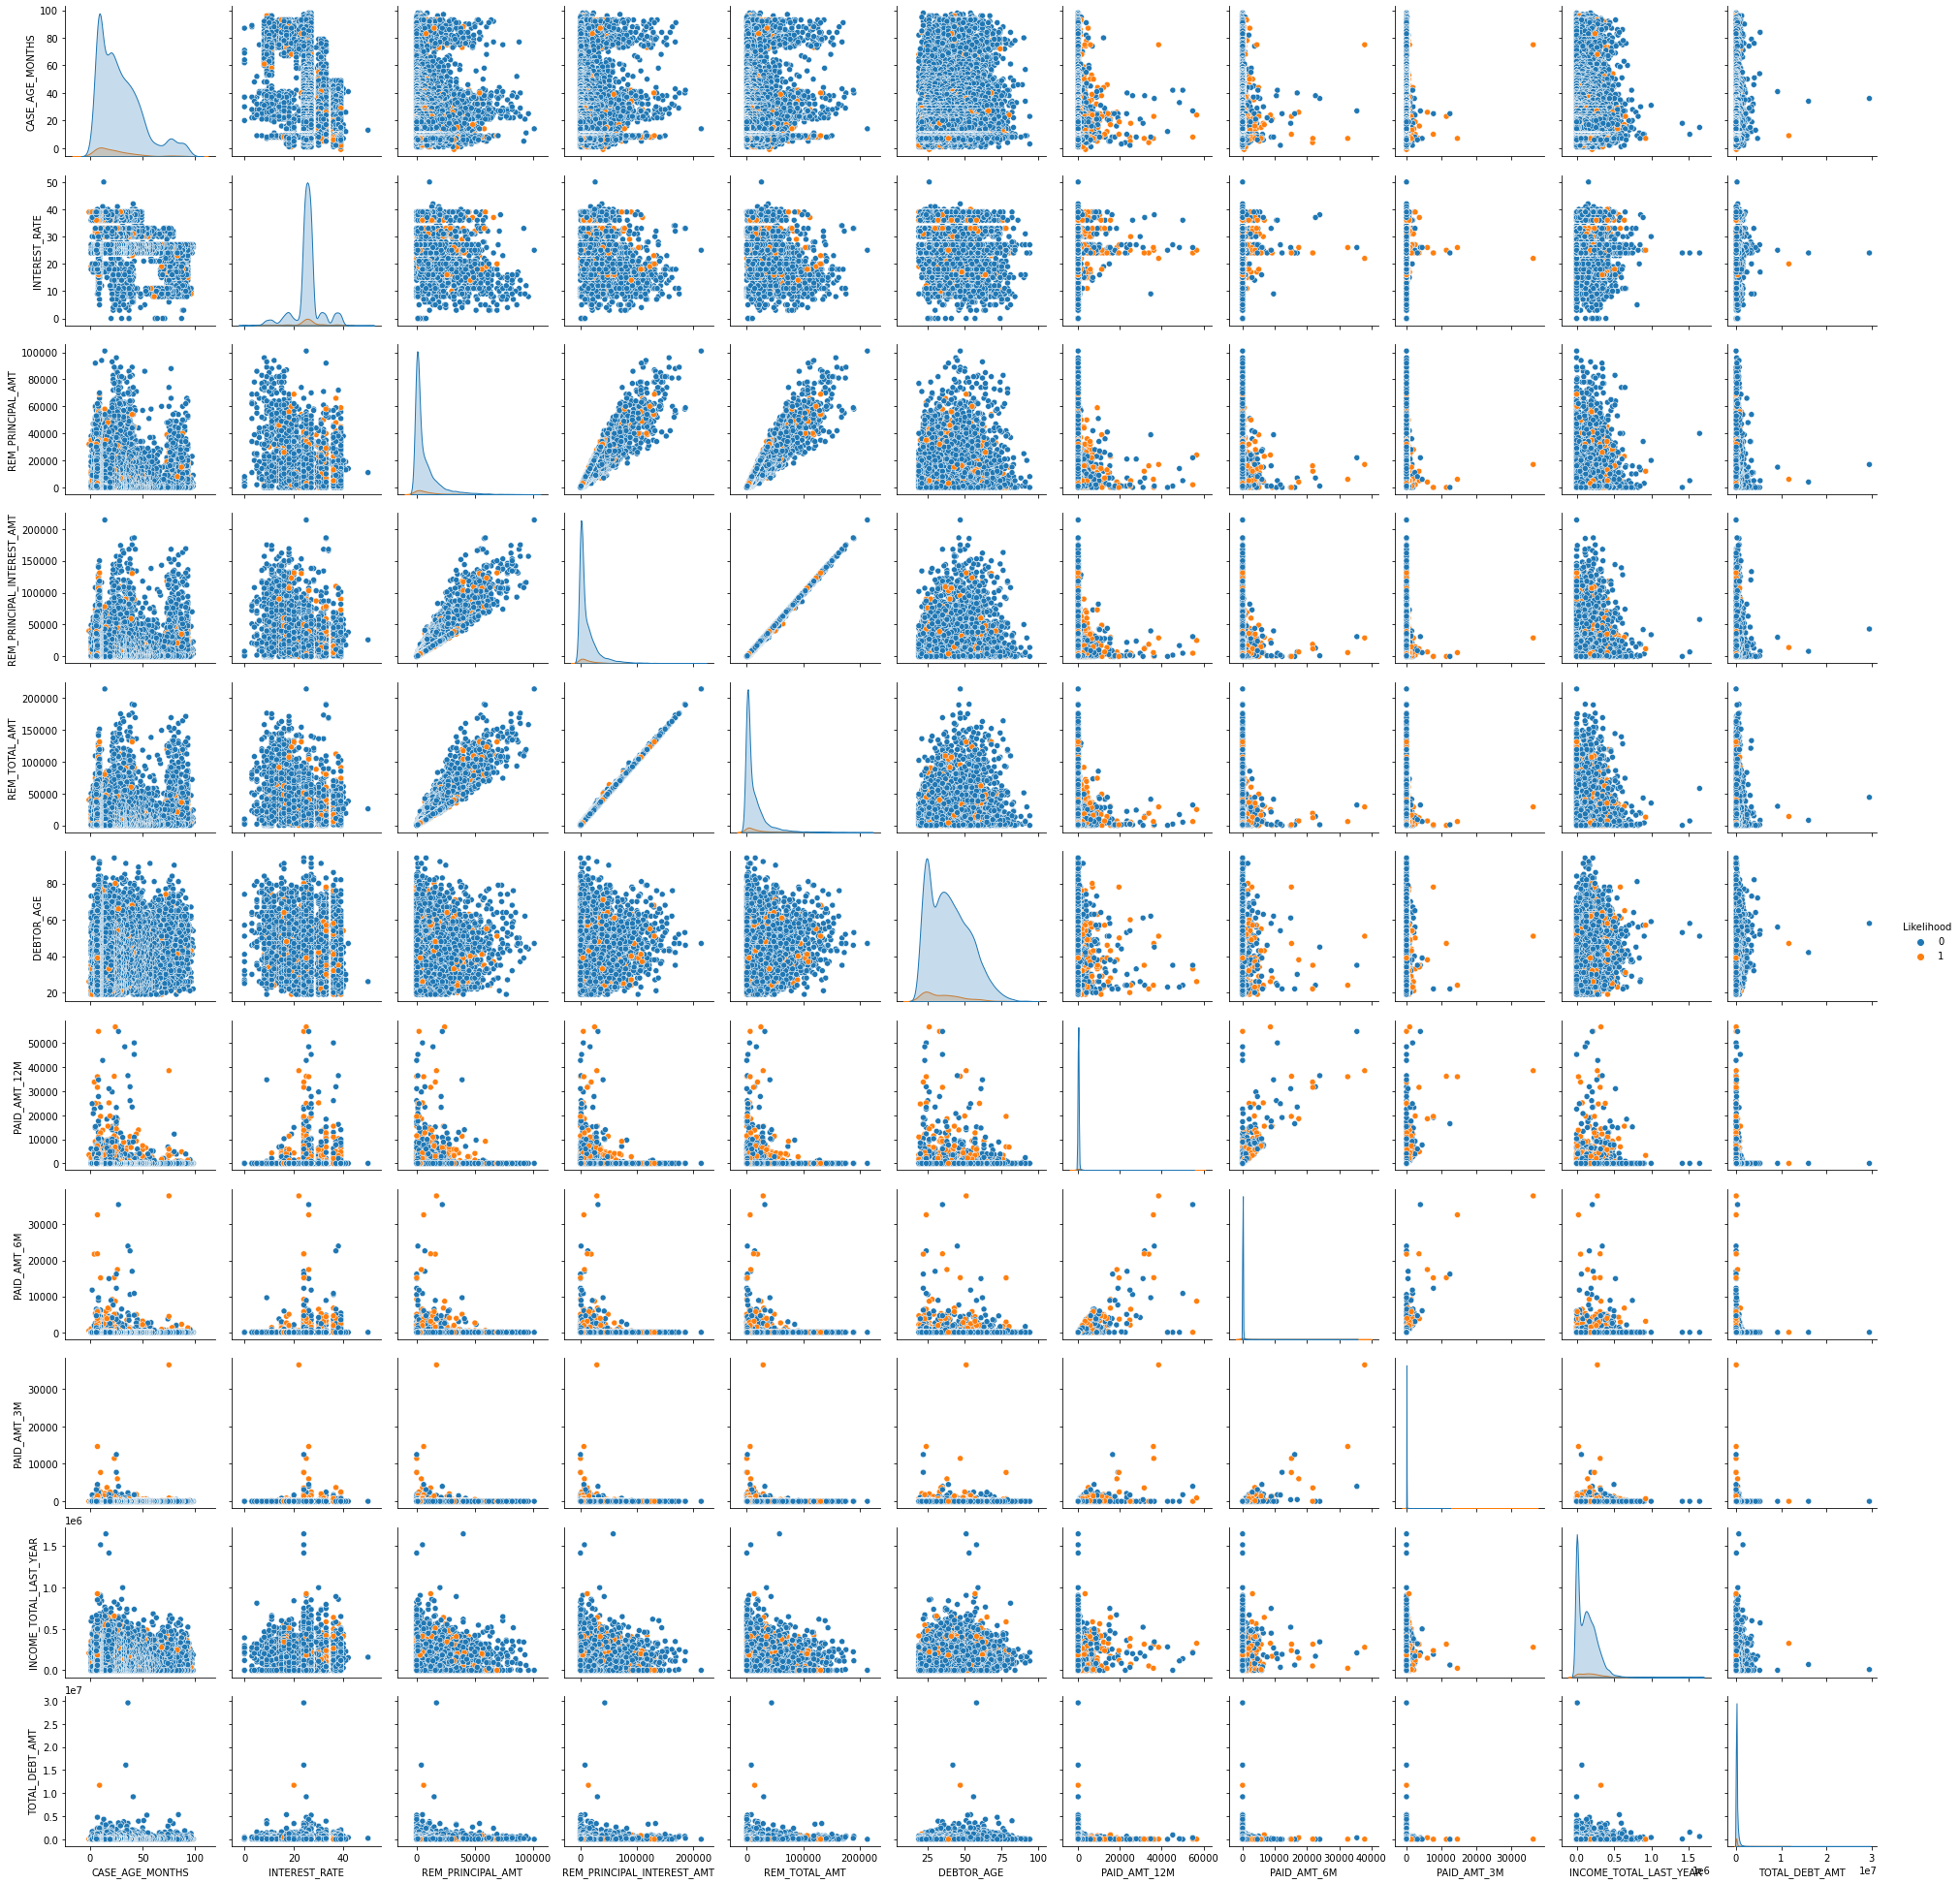

In [18]:
# pair plot of data which hue likelihood

sns.pairplot(Cleaned_Data, hue='Likelihood')

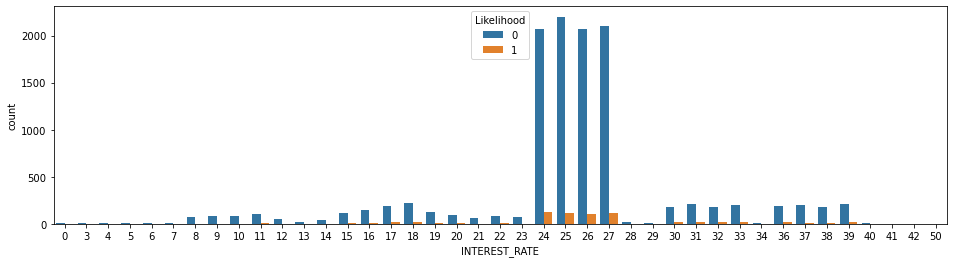

In [19]:
# The following count plot indicates the number of paids are  much smaller than not paid. moreover, the intrest rate
# in both cases are around 24 to 27approximately.

plt.figure(figsize=(16,4))
ax=sns.countplot(data=Cleaned_Data,x='INTEREST_RATE', hue='Likelihood')

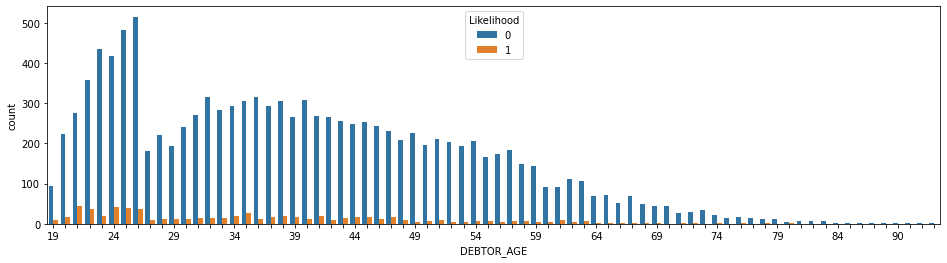

In [20]:
# This countplot shows the deptors age and the likelihood of their payment. The higher numbers of unpaid correspond to
# pepole with age around 22 to 26 years old.

plt.figure(figsize=(16,4))
ax=sns.countplot(data=Cleaned_Data,x='DEBTOR_AGE', hue='Likelihood')

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

<AxesSubplot:xlabel='REM_PRINCIPAL_AMT'>

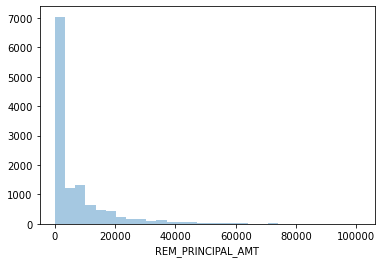

In [21]:
sns.distplot(Cleaned_Data['REM_PRINCIPAL_AMT'],kde=False, bins=30)

<AxesSubplot:>

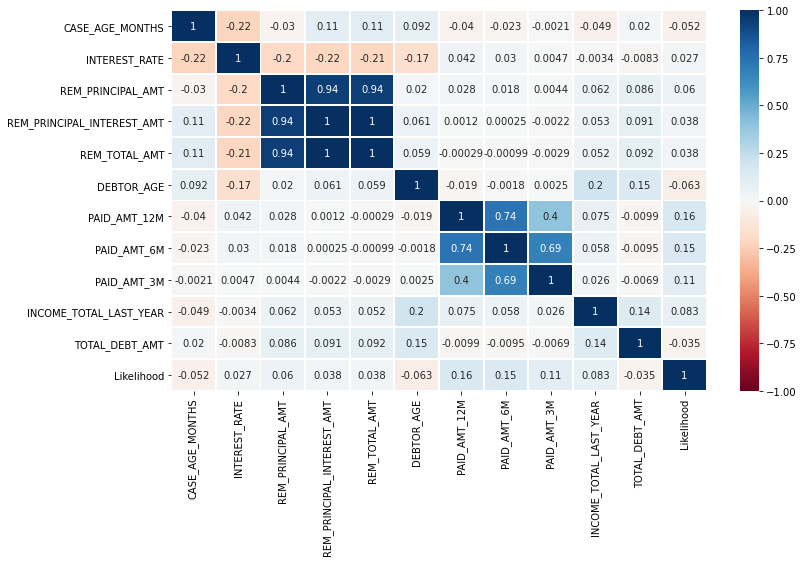

In [22]:
# Correlation between columns, columns  'REM_PRINCIPAL_AMT', 'REM_PRINCIPAL_INTEREST_AMT' and  'REM_TOTAL_AMT' 
# are highly correlated. Which makes sense, as they are related.

plt.figure(figsize=(12,7))
sns.heatmap(Cleaned_Data.corr(),linewidths=0.9,cmap= 'RdBu',annot=True,vmin=-1,vmax=1)

<AxesSubplot:xlabel='INCOME_TOTAL_LAST_YEAR', ylabel='REM_TOTAL_AMT'>

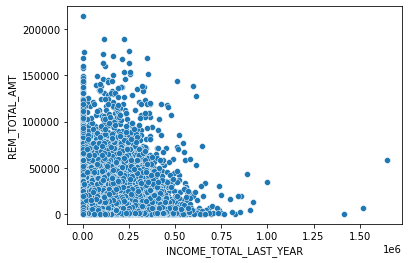

In [23]:
# this indicates the concentrated area.

sns.scatterplot(y='REM_TOTAL_AMT',x='INCOME_TOTAL_LAST_YEAR',data=Cleaned_Data)

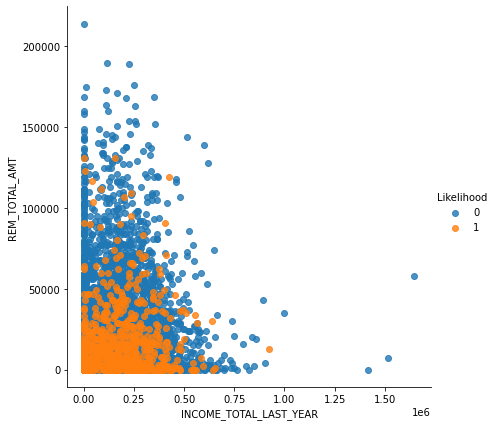

In [24]:
# like the previous one but for separate likelihoods.

sns.lmplot(y='REM_TOTAL_AMT',x='INCOME_TOTAL_LAST_YEAR',data=Cleaned_Data,hue='Likelihood',fit_reg=False,size=6,aspect=1)

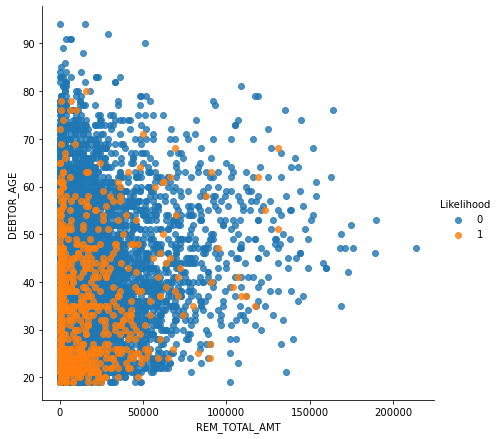

In [25]:
sns.lmplot(x='REM_TOTAL_AMT',y='DEBTOR_AGE',data=Cleaned_Data,hue='Likelihood',fit_reg=False,size=6,aspect=1)

<AxesSubplot:xlabel='Likelihood', ylabel='REM_TOTAL_AMT'>

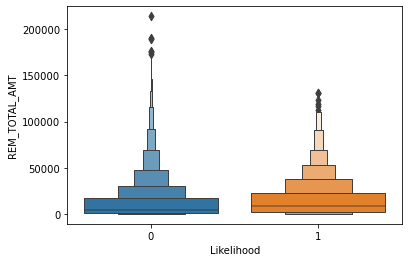

In [26]:
# This indicates several points:  The data are not uniformely or symmetricly distributed. The zero
# case is more skewed. For zero case, the median is smaller thank the one case in terms of 'REM_TOTAL_AMT'. There are
# data with  high 'REM_TOTAL_AMT' which the likelihood is zero for them.
#that for very small 'REM_TOTAL_AMT'  for higher 'REM_TOTAL_AMT' the cases are more toward not-paid.

sns.boxenplot(x='Likelihood',y='REM_TOTAL_AMT',data=Cleaned_Data)

<AxesSubplot:xlabel='Likelihood', ylabel='INCOME_TOTAL_LAST_YEAR'>

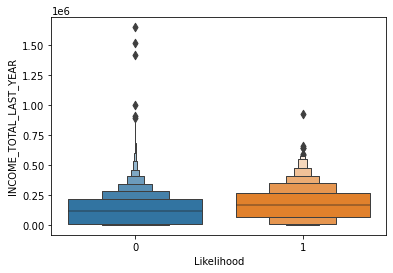

In [27]:
# similar interpretition as the previous one. The median of 'INCOME_TOTAL_LAST_YEAR' was smaller for case of
# likelihood zero. Moreover,there are data which indicates for very high 'INCOME_TOTAL_LAST_YEAR' there is zero likelihood.

sns.boxenplot(y='INCOME_TOTAL_LAST_YEAR',x='Likelihood',data=Cleaned_Data)

<AxesSubplot:>

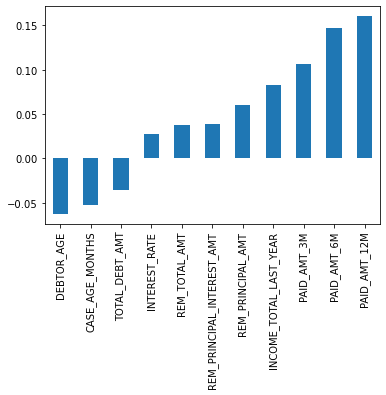

In [28]:
# Sorting correlation between data. Deptor age has negative correlayion with likelihood. The younger the pepole
# the lower the likelihood of payment. The higher the Paymnt in last 12 month, thehigher of likelood of payment.

Cleaned_Data.corr()['Likelihood'].sort_values().drop('Likelihood').plot(kind='bar')

# Over_sampling the data

In [29]:
# We have highly imbalace data as seen above. One other important step for this task is how to deal with imbalance data. There are some approchs to make the 
#data balaced. Like oversampling or undersampling. I have tried both and prefered to go with oversampling, due to
# accuracy outcome.

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
sm = SMOTE(sampling_strategy='minority',k_neighbors=5)

In [30]:
# Cleaned_Data_sm is over_samaled data:

Cleaned_Data_sm, y_sm = sm.fit_resample(Cleaned_Data.iloc[:,:-1],Cleaned_Data['Likelihood'])

In [31]:
Data_sm=pd.concat([Cleaned_Data_sm,y_sm],axis=1)

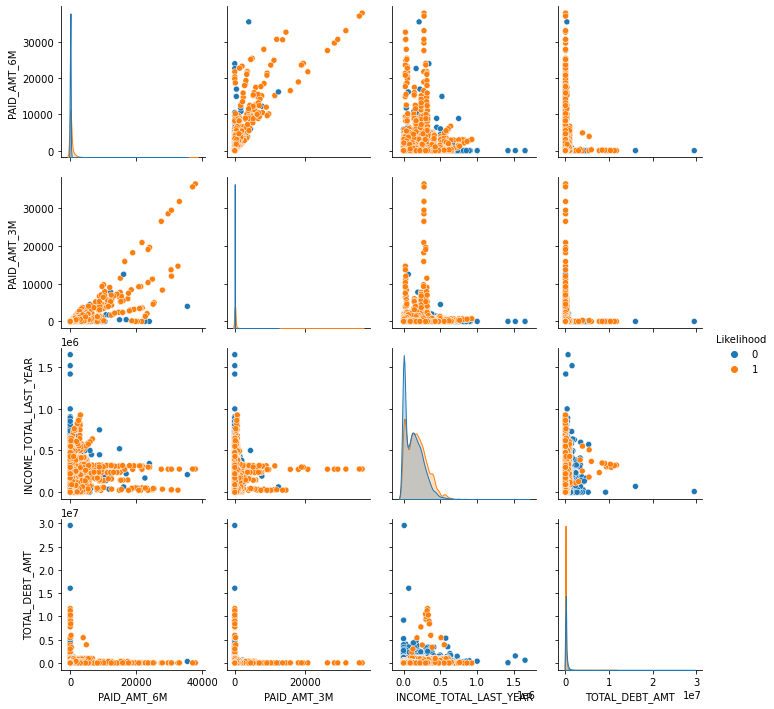

In [32]:
# The pairplot show balanced data

sns.pairplot(Data_sm.iloc[:,7:], hue='Likelihood')

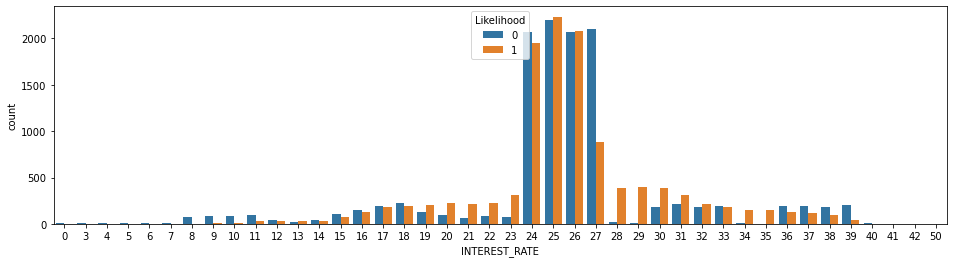

In [33]:
# We go therough some exploration of over_sampled data.

plt.figure(figsize=(16,4))
ax=sns.countplot(data=Data_sm,x='INTEREST_RATE', hue='Likelihood')

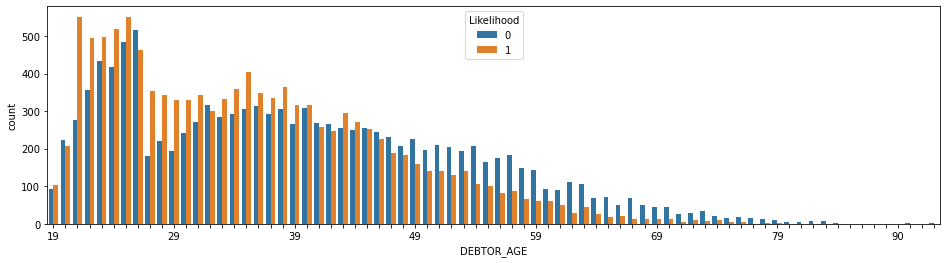

In [34]:
plt.figure(figsize=(16,4))

ax=sns.countplot(data=Data_sm,x='DEBTOR_AGE', hue='Likelihood')
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)

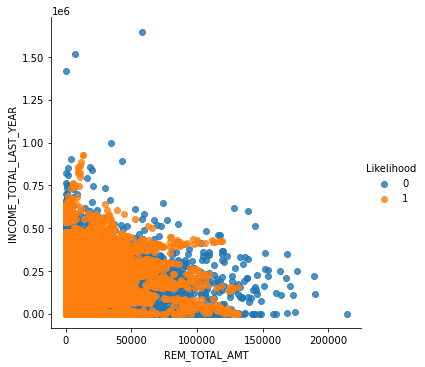

In [35]:
sns.lmplot(x='REM_TOTAL_AMT',y='INCOME_TOTAL_LAST_YEAR',data=Data_sm,hue='Likelihood',fit_reg=False,size=5,aspect=1)

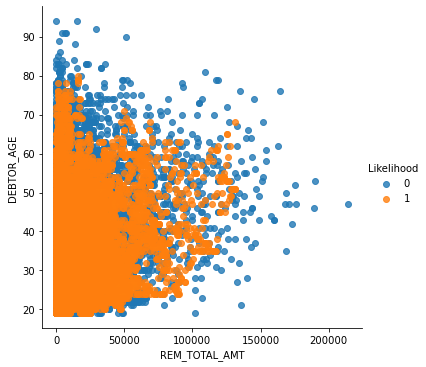

In [36]:
sns.lmplot(x='REM_TOTAL_AMT',y='DEBTOR_AGE',data=Data_sm,hue='Likelihood',fit_reg=False,size=5,aspect=1)